In [1]:
import numpy as np
from zeros import *

def OstarO(A, n=7):
    return (A.T @ A).round(n)

In [2]:
m = 5 # Number of measurements
k = 2 # Rank of O^*O

## Diagonalized prior 
prior = np.eye(m) * 100
prior[0,0] = 0.1
prior[1,1] = 0.2
prior[2,2] = 4

## The posterior precision at the first k eigenvectors 
precision = m/k + np.mean(np.diag(prior)[:k])


# M = O^*O
M = np.zeros((m,m))
for i in range(k):
    M[i,i] = precision - prior[i,i]

## Find O such that O^*O = M and O has unit norm rows
O = get_A(M, m).T
OstarO(O)

## Since O[2,:] = -O[4,:] we have clusterization

array([[2.55, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 2.45, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

# Clustered


In [ ]:
m = 5 ## Number of measurements
k = 2 ## RankO^*O

o1o2 = get_A(np.diag([0.55, 1.45]), k).T

O = np.zeros((m,k))
O[:2,:2] = o1o2
O[2,1] = 1
O[3,0] = 1
O[4,0] = 1

# Returns O^*O
OstarO(O)

# Not Clustered


In [4]:
m = 5
k = 2

o1o2 = get_A(np.diag([0.75, 1.25]), k).T
o3o4 = get_A(np.diag([0.8, 1.2]), k).T

O = np.zeros((m,k))
O[:2,:2] = o1o2 
O[2:4,:2] = o3o4
O[4,0] = 1

# Returns O^*O
print(OstarO(O))

# Looks nicer
O = np.array([
    [np.sqrt(3/8), -np.sqrt(5/8)],
    [np.sqrt(3/8),  np.sqrt(5/8)],
    [np.sqrt(2/5), -np.sqrt(3/5)],
    [np.sqrt(2/5),  np.sqrt(3/5)],
    [1,             0           ]        
])

# Returns O^*O
print(OstarO(O))

[[2.55 0.  ]
 [0.   2.45]]
[[2.55 0.  ]
 [0.   2.45]]


# Example of clusterization:
We show an example of clusterization in the inverse problem of the 1D heat equation. The inverse problem is implemented in the frequency domain via Fourier multipliers, where the Laplace operator is diagonal. See code in src/ for details on the implementation.

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from joblib import Parallel, delayed

from scipy.linalg import solve
from scipy.optimize import minimize, LinearConstraint

from src.probability import Prior, Posterior
from src.forward import Heat
from src.observations import PointObservation, DiagObservation
from src.multiplier import FourierMultiplier

%matplotlib


sig = 5e-2 ## Observation error
N = 200 ## Number of discretization points in the domain
L = 1 ## Length of the domain
time = 3e-2 ## Time for a forward run the heat equation (i.e. time of heat dissipation)
alpha = 1. ## Coefficient
gamma = -1.
model_error = 0 ## Coefficient of model error term. if  == 0  then no model error is present.


## DST / DCT - discrete sine / cosine transform. 
## Corresponds to a homogeneous Dirichlet/ Neumann boundary condition.
## Clusterization also happens with Neumann boundary, I just chose to present 
## Dirichlet boundary in the paper
dst, dct = {}, {}
for transform in  ['dst']:#, 'dct']:
    delta = 0. if transform == 'dst' else 0.5
    fwd = Heat(N=N, L=L, transform=transform, alpha=alpha, time=time)
    pr = Prior(N=N, L=L, transform=transform, gamma=gamma, delta=delta)
   
    post = Posterior(fwd=fwd,
                     prior=pr,
                     sigSqr=sig**2,
                     L=L,
                     N=N,
                     transform=transform,
                     model_error=model_error
                     ) 
    dic = dst if transform == 'dst' else dct
    for m in range(3,6):
        print(m, end=' ')
        res = post.optimize(m=m, n_iterations=250, n_jobs=-1)
        design = res['x']
        dic[m] = design
        print(design)


fs = 24
fig, ax = plt.subplots(figsize=(10,5))

for m, array in dst.items():
    colors = iter(list("brgkm"))

    vals = np.repeat(m, len(array))
    ax.scatter(array, vals, s=0)
    for i, val in enumerate(array):
        ax.annotate(str(i+1),
                    xy=(val, m),
                    ha='center', 
                    va='center',
                    fontsize=fs,
                    color=next(colors))
            

ax.set_xlabel('Measurement Location', fontsize=fs)
ax.set_ylabel('No. of Measurements', fontsize=fs)
ax.set_yticks(list(dst.keys()))
ax.set_xlim(0,1)
plt.tight_layout()

plt.show()
#plt.savefig("latex/example.pdf")
#plt.close()


Using matplotlib backend: QtAgg
3 [0.26572189 0.63938115 0.78846612]
4 [0.21231986 0.32843671 0.66656332 0.78268017]
5 [0.22932261 0.22932265 0.49749985 0.76567723 0.7656773 ]


In [49]:
meas = [0.2, 0.2]
N = 3

pr = probability.Prior(N=N, L=L, transform=transform, gamma=gamma, delta=delta)

obs = PointObservation(N=N, L=L, transform=transform, measurements=meas)
m = len(meas)
model_error_covariance = pr.multiplier
Sigma = 5e-2 *np.eye(m) + np.einsum('ik, k, kj->ij', obs.multiplier, model_error_covariance, obs.multiplier.conjugate().T)
OstarO = obs.multiplier.conjugate().T @ np.linalg.solve(Sigma, obs.multiplier)

OstarO
obs.multiplier

array([[ 1.29194838,  1.05096549, -0.30901699],
       [ 1.29194838,  1.05096549, -0.30901699]])

# Eigenvectors and clusterization

In [6]:
import numpy as np
from matplotlib import pyplot as plt

from src.probability import Prior, Posterior
from src.forward import Heat
from src.observations import PointObservation, DiagObservation

%matplotlib

sig = 5e-2
N = 200
L = 1
time = 3e-2
alpha = 1.
gamma = -1.
m = 4
transform = 'dst'
delta = 0. if transform == 'dst' else 0.5

fwd = Heat(N=N, L=L, transform=transform, alpha=alpha, time=time)
pr = Prior(N=N, L=L, transform=transform, gamma=gamma, delta=delta)
post = Posterior(fwd=fwd,
                 prior=pr,
                 sigSqr=sig**2,
                 L=L,
                 N=N,
                 transform=transform)

res = post.optimize(m=m, n_iterations=250)
print(res['x'])

Using matplotlib backend: QtAgg
[0.3066907  0.30669072 0.68830928 0.6883093 ]


In [7]:
plt.close('all')
fig = plt.figure(figsize=(8,4))
fs = 18
lss = ['solid', 'dotted', 'dashed', 'dashdot']
vals = np.zeros(m)
plt.scatter(res['x'], vals)
x = fwd.x
for i,ls in enumerate(lss):
    ev = fwd.eigenvector(i)
    lam = np.sqrt(fwd.multiplier[i])
    plt.plot(x, ev * lam, label=i+1, ls=ls)
plt.plot([0,1], [0,0], ls='-', color='k', alpha=0.5)    
plt.xlabel(r"$x \in \Omega$", fontsize=fs)
plt.legend(title='eigenvector, weighted')
plt.tight_layout()
plt.savefig("latex/eigenvectors.pdf")
#plt.close('all')

# Generate animations of 1D heat equation: forward and backwards in time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from src.forward import Heat
from src.probability import Prior

%matplotlib

np.random.seed(19)

plt.close('all')
sig = 5e-2

n = 800
N = 500
L = 1
delta_t = 1e-5
alpha = 1e-8
gamma = -1.2
acceleration = 3

pr = Prior(N=N, L=L, transform='dst', gamma=gamma, delta=0.)
u = pr.sample(n_sample=100)
ind = np.where(np.all(u > 0, axis=1))[0]
u = u[ind[0],:]


us = [u]
times = [0]
for k in range(n):
    dt = delta_t*k**acceleration
    fwd = Heat(N=N, L=L, transform='dst', alpha=alpha, time=dt)
    u = fwd(u)
    us.append(u)
    times.append(times[-1] + dt)
us = np.vstack(us)
print('Done forward simulation')

fig, ax = plt.subplots()
line, = ax.plot(fwd.x, us[0, :], color='k')
ax.set_xlim(0, 1)
#ax.set_ylim(np.min(u), np.max(u))
ax.set_xlabel('Position')
ax.set_ylabel('Temperature')
plt.savefig('forward_heat_equation.png')

time_template = 'Time elapsed {}' 
time_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, ha='right', va='top')

def update(frame):
    tt = times[frame]#tt = frame**acceleration * time    
    tt = int(tt)
    time_text.set_text(time_template.format(tt))
    line.set_ydata(us[frame, :])
    return line, time_text

ani = animation.FuncAnimation(fig, update, frames=n, blit=True)
ani.save('forward_heat_equation.mp4', writer='ffmpeg', fps=30)
print('Done forward animation')
plt.show()

plt.close('all')

## Reverse
fig, ax = plt.subplots()
line, = ax.plot(fwd.x, us[-1, :], color='k')
ax.set_xlim(0, 1)
#ax.set_ylim(np.min(u), np.max(u))
ax.set_xlabel('Position')
ax.set_ylabel('Temperature')
plt.savefig('reverse_heat_equation.png')


u_reversed = us[::-1]
time_reversed = np.array(times)[::-1]
time_template = 'Time elapsed {}' 
time_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, ha='right', va='top')

def update(frame):
    tt = time_reversed[frame]#tt = frame**acceleration * time   
    tt = int(tt)
    time_text.set_text(time_template.format(tt))
    line.set_ydata(u_reversed[frame, :])
    return line, time_text

ani = animation.FuncAnimation(fig, update, frames=n, blit=True)
ani.save('reversed_heat_equation.mp4', writer='ffmpeg', fps=30)
print('Done backwards animation')
plt.show()


Using matplotlib backend: QtAgg
Done forward simulation
Done forward animation
Done backwards animation


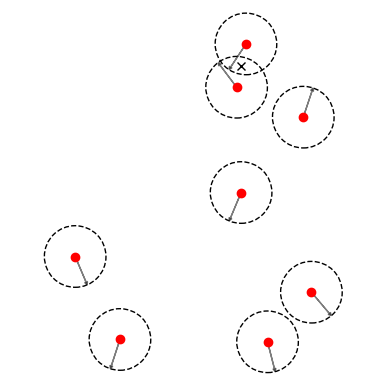

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# Function to check for circle overlap
def circles_overlap(center1, center2, radius):
    return np.linalg.norm(center1 - center2) < 2 * radius

# Generate random points
np.random.seed(18)
points = np.random.rand(8, 2) * 10
w = 0.1
radius = 1.0 

# Plotting
fig, ax = plt.subplots()

# Plot points and circles
for point in points:
    ax.plot(point[0], point[1], 'ro')  # Plot the point
    circle = plt.Circle(point, radius, edgecolor='black', linestyle='--', fill=False)
    ax.add_artist(circle)  # Add the circle
    # Generate random angle for the arrow
    angle = np.random.rand() * 2 * np.pi
    dx = (radius-w) * np.cos(angle)
    dy = (radius-w) * np.sin(angle)
    ax.arrow(point[0], point[1], dx, dy, head_width=w, head_length=w, fc='black', ec='black', alpha=0.5)  # Arrow with opacity

# Check for overlaps and mark with X
for (i, j) in combinations(range(len(points)), 2):
    if circles_overlap(points[i], points[j], radius):
        midpoint = (points[i] + points[j]) / 2
        ax.plot(midpoint[0], midpoint[1], 'kx')  # Mark overlap with 'X'

# Set plot limits and remove axes
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')  # Remove the axes

plt.savefig('constraints.png')
plt.show()


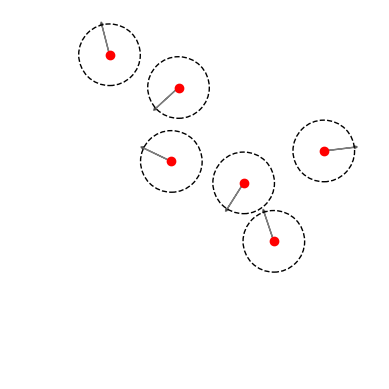

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# Function to check for circle overlap
def circles_overlap(center1, center2, radius):
    return np.linalg.norm(center1 - center2) < 2 * radius

# Function to find close points and merge them
def merge_close_points(points, threshold):
    merged = True
    while merged:
        merged = False
        new_points = []
        skip_indices = set()
        for i, j in combinations(range(len(points)), 2):
            if i not in skip_indices and j not in skip_indices:
                if np.linalg.norm(points[i] - points[j]) < threshold:
                    new_point = (points[i] + points[j]) / 2
                    new_points.append(new_point)
                    skip_indices.add(i)
                    skip_indices.add(j)
                    merged = True
                    break
        for i in range(len(points)):
            if i not in skip_indices:
                new_points.append(points[i])
        points = np.array(new_points)
    return points

# Generate random points
#np.random.seed(0)
points = np.random.rand(10, 2) * 10
radius = 1.0

# Merge close points
threshold_distance = 2 * radius
points = merge_close_points(points, threshold_distance)

# Plotting
fig, ax = plt.subplots()

# Plot points and circles
for point in points:
    ax.plot(point[0], point[1], 'ro')  # Plot the point
    circle = plt.Circle(point, radius, edgecolor='black', linestyle='--', fill=False)
    ax.add_artist(circle)  # Add the circle
    # Generate random angle for the arrow
    angle = np.random.rand() * 2 * np.pi
    dx = radius * np.cos(angle)
    dy = radius * np.sin(angle)
    ax.arrow(point[0], point[1], dx, dy, head_width=0.1, head_length=0.1, fc='black', ec='black', alpha=0.5)  # Arrow with opacity

# Check for overlaps and mark with X
for (i, j) in combinations(range(len(points)), 2):
    if circles_overlap(points[i], points[j], radius):
        midpoint = (points[i] + points[j]) / 2
        ax.plot(midpoint[0], midpoint[1], 'kx')  # Mark overlap with 'X'

# Set plot limits and remove axes
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')  # Remove the axes

plt.show()


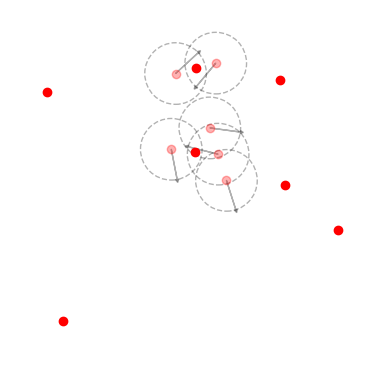

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# Function to check for circle overlap
def circles_overlap(center1, center2, radius):
    return np.linalg.norm(center1 - center2) < 2 * radius

# Function to find close points and merge them, while keeping old points
def merge_close_points(points, threshold):
    merged = True
    old_points = []
    while merged:
        merged = False
        new_points = []
        skip_indices = set()
        for i, j in combinations(range(len(points)), 2):
            if i not in skip_indices and j not in skip_indices:
                if np.linalg.norm(points[i] - points[j]) < threshold:
                    new_point = (points[i] + points[j]) / 2
                    new_points.append(new_point)
                    old_points.append(points[i])
                    old_points.append(points[j])
                    skip_indices.add(i)
                    skip_indices.add(j)
                    merged = True
                    break
        for i in range(len(points)):
            if i not in skip_indices:
                new_points.append(points[i])
        points = np.array(new_points)
    return points, old_points

# Generate random points
np.random.seed(0)
points = np.random.rand(10, 2) * 10
radius = 1.0

# Merge close points
threshold_distance = 2 * radius
new_points, old_points = merge_close_points(points, threshold_distance)

# Plotting
fig, ax = plt.subplots()

# Plot old points and circles in pale red
for point in old_points:
    ax.plot(point[0], point[1], 'ro', alpha=0.3)  # Plot the old point
    circle = plt.Circle(point, radius, edgecolor='black', linestyle='--', fill=False, alpha=0.3)
    ax.add_artist(circle)  # Add the circle
    # Generate random angle for the arrow
    angle = np.random.rand() * 2 * np.pi
    dx = radius * np.cos(angle)
    dy = radius * np.sin(angle)
    ax.arrow(point[0], point[1], dx, dy, head_width=0.1, head_length=0.1, fc='black', ec='black', alpha=0.3)  # Arrow with opacity

# Plot new points without circles
for point in new_points:
    ax.plot(point[0], point[1], 'ro')  # Plot the new point

# Check for overlaps and mark with X
for (i, j) in combinations(range(len(new_points)), 2):
    if circles_overlap(new_points[i], new_points[j], radius):
        midpoint = (new_points[i] + new_points[j]) / 2
        ax.plot(midpoint[0], midpoint[1], 'kx')  # Mark overlap with 'X'

# Set plot limits and remove axes
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')  # Remove the axes

plt.show()


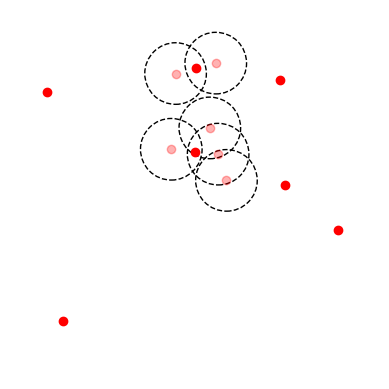

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# Function to check for circle overlap
def circles_overlap(center1, center2, radius):
    return np.linalg.norm(center1 - center2) < 2 * radius

# Function to find close points and merge them, while keeping old points
def merge_close_points(points, threshold):
    merged = True
    old_points = []
    while merged:
        merged = False
        new_points = []
        skip_indices = set()
        for i, j in combinations(range(len(points)), 2):
            if i not in skip_indices and j not in skip_indices:
                if np.linalg.norm(points[i] - points[j]) < threshold:
                    new_point = (points[i] + points[j]) / 2
                    new_points.append(new_point)
                    old_points.append(points[i])
                    old_points.append(points[j])
                    skip_indices.add(i)
                    skip_indices.add(j)
                    merged = True
                    break
        for i in range(len(points)):
            if i not in skip_indices:
                new_points.append(points[i])
        points = np.array(new_points)
    return points, old_points

# Generate random points
np.random.seed(0)
points = np.random.rand(10, 2) * 10
radius = 1.0

# Merge close points
threshold_distance = 2 * radius
new_points, old_points = merge_close_points(points, threshold_distance)

# Plotting
fig, ax = plt.subplots()

# Plot old points and circles in pale red
for point in old_points:
    ax.plot(point[0], point[1], 'ro', alpha=0.3)  # Plot the old point
    circle = plt.Circle(point, radius, edgecolor='black', linestyle='--', fill=False)
    ax.add_artist(circle)  # Add the circle

# Plot new points without circles
for point in new_points:
    ax.plot(point[0], point[1], 'ro')  # Plot the new point

# Check for overlaps and mark with X
for (i, j) in combinations(range(len(new_points)), 2):
    if circles_overlap(new_points[i], new_points[j], radius):
        midpoint = (new_points[i] + new_points[j]) / 2
        ax.plot(midpoint[0], midpoint[1], 'kx')  # Mark overlap with 'X'

# Set plot limits and remove axes
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')  # Remove the axes

plt.show()


# Figure for talk

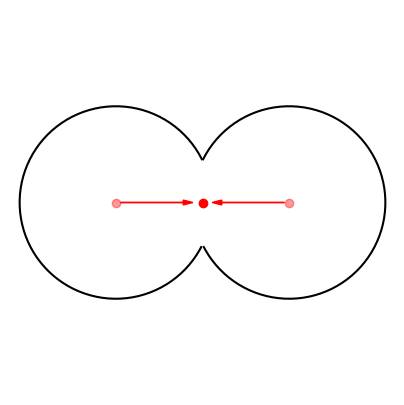

In [109]:
grid = np.linspace(0, 2*np.pi, num=200)

circle = np.vstack([np.sin(grid), np.cos(grid)]).T

x1 = np.array([0.9,0])
circ1 = circle + x1
ind = np.where(circ1[:,0] > 0)[0]
shift = -np.diff(ind).argmax()-1
circ1 = np.roll(circ1, shift, axis=0)
ii = np.where(circ1[:,0] > 0)[0]
circ1 = circ1[ii,:]


circ2 = circ1.copy()
circ2[:,0] = -circ2[:,0]

plt.figure(figsize=(5,5))
plt.plot(circ1[:,0], circ1[:,1], color='k')
plt.plot(circ2[:,0], circ2[:,1], color='k')


plt.scatter(0,0, color='r')
plt.scatter([0.9, -0.9], [0,0], color='r', alpha=0.4)

plt.arrow(0.85, 0, -0.65, 0, head_width=0.05, head_length=0.1, fc='r', ec='r')
plt.arrow(-0.85, 0, 0.65, 0, head_width=0.05, head_length=0.1, fc='r', ec='r')

plt.xlim(-2,2)
plt.ylim(-2,2)

plt.gca().set_aspect('equal', adjustable='box')

# Remove the plot border (spines)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xticks([])
plt.yticks([])

plt.savefig('merge.png')

array([[ 6.00000000e-01,  1.00000000e+00],
       [ 6.00000000e-01,  1.00000000e+00],
       [ 6.00000000e-01, -1.00000000e+00],
       [ 1.30710678e+00,  7.07106781e-01],
       [ 1.30710678e+00, -7.07106781e-01],
       [ 1.60000000e+00,  6.12323400e-17]])